<a href="https://colab.research.google.com/github/Jarvis-X/Aerial-Robotics-Course-Projects/blob/main/CS498HW4DoublePen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [160]:
import numpy as np
import cvxpy as cp

# initial states: [x0, y0, theta10, theta20, dx0, dy0, dtheta10, dtheta20]
x0 = [0, 0, 0, 0, 0, 0, 0, 0]
# masses
m1, m2 = 1.0, 2.0
# half length of the rod
l = 1.0
# tilting angles of the inner propellers
alpha = np.pi/4
beta = 3*np.pi/4
# Do we want constains?
en_constrain = True
# simulation time
time_out = 20

# Here, different from before, we have many hard coded parameters embedded in the dynamics
# number of propellers
n = 4
# gravity acceleration
g = 9.8
# time step
dt = 0.001
# max force of a propeller
fM = 200.0
# minimum force of a propeller
fm = -200.0
# desired state
des_state = np.array([-1, 2, -0.5, 1, 0, 0, 0, 0])


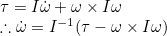

Because we constrained the input force as a positive one, we need a damping term to slow down the rod. Thus we added the damping factor

In [161]:
# step function for the motion of the system
def step(state, u):
    x, y, theta1, theta2, dx, dy, dtheta1, dtheta2 = state
    # calculate the derivative of the states
    # I hope this part works for the first pass otherwise it will be painful
    ### debug log 1: forgot the torque from the gravity
    ### debug log 2: rewrite the euler functions, assuming normal mass distribution on both segments,
    ###### drop changes in log 1
    ### debug log 3: I miswrote a "m1" as "m2" in the Mathematica equations LoL
    ### debug log 4: I miswrote a "+" as "-" in Mathematica :(
    ### debug log 5: I missed a square :<
    # With above changes, the dynamics is working now :DDD
    M = np.array([[m1+m2, 0, l*(m1*np.sin(theta1)-m2*np.sin(theta1+theta2)), -l*m2*np.sin(theta1+theta2)],
                  [0, m1+m2, -l*m1*np.cos(theta1)+l*m2*np.cos(theta1+theta2), l*m2*np.cos(theta1+theta2)],
                  [6*l*m1*np.sin(theta1), -6*l*m1*np.cos(theta1), 8*l**2*m1, 0],
                  [6*l*m1*np.sin(theta1+theta2), -6*l*m1*np.cos(theta1+theta2), 6*l**2*m1*np.cos(theta2), 2*l**2*m2]])
    
    b = np.array([2*dtheta1*dtheta2*l*m2*np.cos(theta1+theta2)+dtheta2**2*l*m2*np.cos(theta1+theta2)-l*dtheta1**2*(m1*np.cos(theta1)-m2*np.cos(theta1+theta2)),
                  -(m1+m2)*g + 2*dtheta1*dtheta2*l*m2*np.sin(theta1+theta2) + dtheta2**2*l*m2*np.sin(theta1+theta2) - l*dtheta1**2*(m1*np.sin(theta1)-m2*np.sin(theta1+theta2)),
                  6*m1*g*l*np.cos(theta1),
                  -6*l*m1*(-g*np.cos(theta1+theta2)+dtheta1**2*l*np.sin(theta2))])
    
    A = np.array([[-np.sin(theta1), np.cos(theta1+alpha), np.cos(theta1+theta2+beta), -np.sin(theta1+theta2)],
                  [np.cos(theta1), np.sin(theta1+alpha), np.sin(theta1+theta2+beta), np.cos(theta1+theta2)],
                  [-9*l, -3*l*np.sin(alpha), 0, 0],
                  [-6*l*np.cos(theta2), -6*l*np.sin(alpha-theta2), -3*l*np.sin(beta), 3*l]])

    # The dynamics: M(X)*d/dt(X) = b(X) + A(X)u
    dstate = np.concatenate([[dx, dy, dtheta1, dtheta2], np.linalg.inv(M).dot(b + A.dot(u))])
    new_state = state + dstate*dt
    # make sure the range of theta is in (-pi, pi]
    if new_state[2] <= -np.pi:
        new_state[2] += 2*np.pi
    elif new_state[2] > np.pi:
        new_state[2] -= 2*np.pi
    if new_state[3] <= -np.pi:
        new_state[3] += 2*np.pi
    elif new_state[3] > np.pi:
        new_state[3] -= 2*np.pi
    return new_state

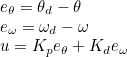

In [162]:
Kp = 1.5
Kd = 1.0
Ktheta = 1.5
Komega = 1.0
def control(state, des_state, en_constrain):
    x, y, theta1, theta2, dx, dy, dtheta1, dtheta2 = state
    # The dynamics: M(X)*d/dt(X) = b(X) + A(X)u
    M = np.array([[m1+m2, 0, l*(m1*np.sin(theta1)-m2*np.sin(theta1+theta2)), -l*m2*np.sin(theta1+theta2)],
                  [0, m1+m2, -l*m1*np.cos(theta1)+l*m2*np.cos(theta1+theta2), l*m2*np.cos(theta1+theta2)],
                  [6*l*m1*np.sin(theta1), -6*l*m1*np.cos(theta1), 8*l**2*m1, 0],
                  [6*l*m1*np.sin(theta1+theta2), -6*l*m1*np.cos(theta1+theta2), 6*l**2*m1*np.cos(theta2), 2*l**2*m2]])
    
    b = np.array([2*dtheta1*dtheta2*l*m2*np.cos(theta1+theta2)+dtheta2**2*l*m2*np.cos(theta1+theta2)-l*dtheta1**2*(m1*np.cos(theta1)-m2*np.cos(theta1+theta2)),
                  -(m1+m2)*g + 2*dtheta1*dtheta2*l*m2*np.sin(theta1+theta2) + dtheta2**2*l*m2*np.sin(theta1+theta2) - l*dtheta1**2*(m1*np.sin(theta1)-m2*np.sin(theta1+theta2)),
                  6*m1*g*l*np.cos(theta1),
                  -6*l*m1*(-g*np.cos(theta1+theta2)+dtheta1**2*l*np.sin(theta2))])
    
    A = np.array([[-np.sin(theta1), np.cos(theta1+alpha), np.cos(theta1+theta2+beta), -np.sin(theta1+theta2)],
                  [np.cos(theta1), np.sin(theta1+alpha), np.sin(theta1+theta2+beta), np.cos(theta1+theta2)],
                  [-9*l, -3*l*np.sin(alpha), 0, 0],
                  [-6*l*np.cos(theta2), -6*l*np.sin(alpha-theta2), -3*l*np.sin(beta), 3*l]])
    
    err = des_state - state
    if err[2] <= -np.pi:
        err[2] += 2*np.pi
    elif err[2] > np.pi:
        err[2] -= 2*np.pi
    if err[3] <= -np.pi:
        err[3] += 2*np.pi
    elif err[3] > np.pi:
        err[3] -= 2*np.pi

    des_dx = np.array([Kp*err[0]+Kd*err[4], 
                      Kp*err[1]+Kd*err[5], 
                      Ktheta*err[2]+Komega*err[6],
                      Ktheta*err[3]+Komega*err[7]])

    f = np.linalg.inv(A).dot(M.dot(des_dx)-b)
    
    if en_constrain: 
        return clamp(f, fm, fM)
    else:
        return f


def clamp(vec, minimum, maximum):
    for i in range(len(vec)):
        if vec[i] < minimum:
            vec[i] = minimum
        elif vec[i] > maximum:
            vec[i] = maximum
    return vec

In [163]:
def simulate(init_state, time_out=20):
    length = int(time_out//dt)
    state_log = np.zeros((length, 8))
    f_log = np.zeros((length, n))
    state = init_state
    count = 0
    while count < length:
        if count % (length//100) == 0:
            print("{} percent".format(count//(length//100)))
        state_log[count, :] = state
        f = control(state, des_state, en_constrain)
        f_log[count, :] = f
        state = step(state, f)
        count += 1
    return state_log, f_log

In [164]:
state_log, f_log = simulate(x0, time_out)
print(len(state_log))

0 percent
1 percent
2 percent
3 percent
4 percent
5 percent
6 percent
7 percent
8 percent
9 percent
10 percent
11 percent
12 percent
13 percent
14 percent
15 percent
16 percent
17 percent
18 percent
19 percent
20 percent
21 percent
22 percent
23 percent
24 percent
25 percent
26 percent
27 percent
28 percent
29 percent
30 percent
31 percent
32 percent
33 percent
34 percent
35 percent
36 percent
37 percent
38 percent
39 percent
40 percent
41 percent
42 percent
43 percent
44 percent
45 percent
46 percent
47 percent
48 percent
49 percent
50 percent
51 percent
52 percent
53 percent
54 percent
55 percent
56 percent
57 percent
58 percent
59 percent
60 percent
61 percent
62 percent
63 percent
64 percent
65 percent
66 percent
67 percent
68 percent
69 percent
70 percent
71 percent
72 percent
73 percent
74 percent
75 percent
76 percent
77 percent
78 percent
79 percent
80 percent
81 percent
82 percent
83 percent
84 percent
85 percent
86 percent
87 percent
88 percent
89 percent
90 percent
91 percen

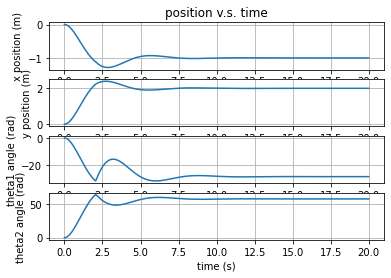

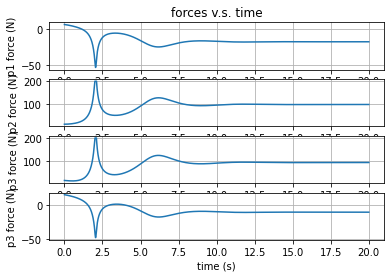

In [165]:
import matplotlib.pyplot as plt

fig1 = plt.figure()
ax11 = fig1.add_subplot(411)
ax11.grid()
ax11.set_ylabel('x position (m)')
ax11.set_title('position v.s. time')
x_position, = ax11.plot(np.linspace(0, time_out, int(time_out//dt)), state_log[:, 0])
# ax11.plot(np.array([0, time_out]), np.array([des_state[0], des_state[0]]))

ax12 = fig1.add_subplot(412)
ax12.grid()
ax12.set_ylabel('y position (m)')
ax12.set_xlabel('time (s)')
y_position, = ax12.plot(np.linspace(0, time_out, int(time_out//dt)), state_log[:, 1])
# ax12.plot(np.array([0, time_out]), np.array([des_state[1], des_state[1]]))

ax13 = fig1.add_subplot(413)
ax13.grid()
ax13.set_ylabel('theta1 angle (rad)')
ax13.set_xlabel('time (s)')
theta1_angle, = ax13.plot(np.linspace(0, time_out, int(time_out//dt)), state_log[:, 2]*180.0/np.pi)
# ax13.plot(np.array([0, time_out]), 180.0/np.pi*np.array([des_state[2], des_state[2]]))

ax14 = fig1.add_subplot(414)
ax14.grid()
ax14.set_ylabel('theta2 angle (rad)')
ax14.set_xlabel('time (s)')
theta2_angle, = ax14.plot(np.linspace(0, time_out, int(time_out//dt)), state_log[:, 3]*180.0/np.pi)
# ax14.plot(np.array([0, time_out]), 180.0/np.pi*np.array([des_state[2], des_state[2]]))

fig2 = plt.figure()
ax21 = fig2.add_subplot(411)
ax21.grid()
ax21.set_ylabel('p1 force (N)')
ax21.set_title('forces v.s. time')
p1f, = ax21.plot(np.linspace(0, time_out, int(time_out//dt)), f_log[:, 0])

ax22 = fig2.add_subplot(412)
ax22.grid()
ax22.set_ylabel('p2 force (N)')
ax22.set_xlabel('time (s)')
p2f, = ax22.plot(np.linspace(0, time_out, int(time_out//dt)), f_log[:, 1])

ax23 = fig2.add_subplot(413)
ax23.grid()
ax23.set_ylabel('p3 force (N)')
ax23.set_xlabel('time (s)')
p3f, = ax23.plot(np.linspace(0, time_out, int(time_out//dt)), f_log[:, 2])

ax24 = fig2.add_subplot(414)
ax24.grid()
ax24.set_ylabel('p3 force (N)')
ax24.set_xlabel('time (s)')
p4f, = ax24.plot(np.linspace(0, time_out, int(time_out//dt)), f_log[:, 3])

In [166]:
!pip install JSAnimation

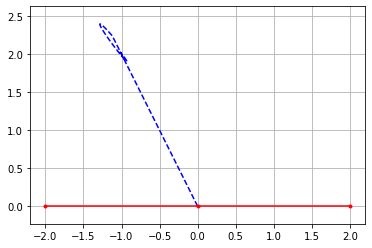

In [167]:
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation import IPython_display
from IPython.display import HTML

fig, ax = plt.subplots()
plt.axis('equal')
sampling = int(100)

def animate(t):
    ax.clear()
    # plt.xlim([-20, 5])
    # plt.ylim([-1, 8])
    ax.grid()
    # Path
    plt.plot(state_log[:, 0], state_log[:, 1], 'b--')
    # # target
    # ax.plot(des_state[0], des_state[1], 'og', markersize=10)
    # ax.arrow(des_state[0], des_state[1], np.cos(des_state[2]), np.sin(des_state[2]), width=0.03, color=[0,0.5,0])

    # current position and orientation
    p = np.zeros([2, 3])
    p[:, 1] = np.array([state_log[sampling*t, 0], 
                   state_log[sampling*t, 1]])
    p[:, 0] = np.array([p[0, 1]-2*l*np.cos(state_log[sampling*t, 2]), 
                   p[1, 1]-2*l*np.sin(state_log[sampling*t, 2])])
    p[:, 2] = np.array([p[0, 1]+2*l*np.cos(state_log[sampling*t, 2] + state_log[sampling*t, 3]), 
                   p[1, 1]+2*l*np.sin(state_log[sampling*t, 2] + state_log[sampling*t, 3])])
    
    ax.plot(p[0, :], p[1, :], 'r.-')  
    
time = int(len(state_log)/sampling)
anim = animation.FuncAnimation(fig, animate, frames=time, interval=dt*1000*sampling)

HTML(anim.to_jshtml())